In [1]:
import sagemaker
sess = sagemaker.Session()
bucket=sess.default_bucket()
prefix = 'sagemaker/DEMO-xgboost-churn'

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import sagemaker
from sagemaker.predictor import csv_serializer

In [3]:
churn = pd.read_csv('./Churn_Modelling.csv')
pd.set_option('display.max_columns', 500)
churn

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


col_0,% observations
Surname,
Abazu,0.0002
Abbie,0.0001
Abbott,0.0004
Abdullah,0.0001
Abdulov,0.0002
...,...
Zubarev,0.0003
Zubareva,0.0001
Zuev,0.0001


col_0,% observations
Geography,
France,0.5014
Germany,0.2509
Spain,0.2477


col_0,% observations
Gender,
Female,0.4543
Male,0.5457


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


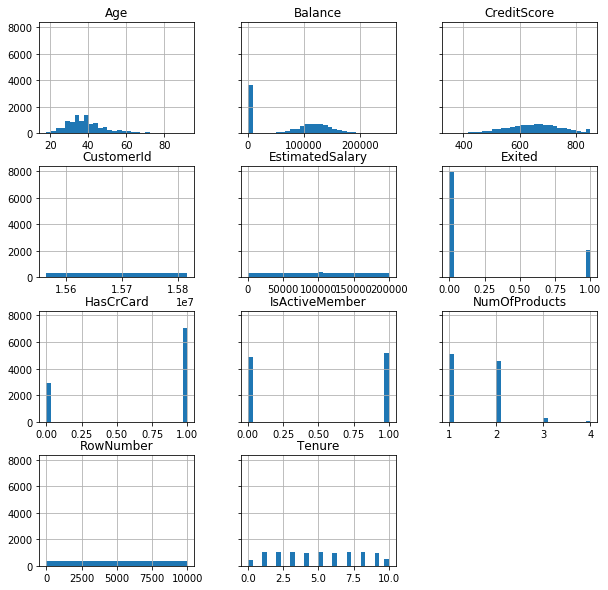

In [4]:
for column in churn.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=churn[column], columns='% observations', normalize='columns'))

# Histograms for each numeric features
display(churn.describe())
%matplotlib inline
hist = churn.hist(bins=30, sharey=True, figsize=(10, 10))

In [5]:
churn = churn.drop('RowNumber',axis=1)
gender = {'Male': 1,'Female': 2} 
  
# traversing through dataframe 
# Gender column and writing 
# values where key matches 

churn['Gender'] = [gender[item] for item in churn['Gender']]
churn

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,2,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,2,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,2,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,2,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,2,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,Obijiaku,771,France,1,39,5,0.00,2,1,0,96270.64,0
9996,15569892,Johnstone,516,France,1,35,10,57369.61,1,1,1,101699.77,0
9997,15584532,Liu,709,France,2,36,7,0.00,1,0,1,42085.58,1
9998,15682355,Sabbatini,772,Germany,1,42,3,75075.31,2,1,0,92888.52,1


In [6]:
geography = {'France': 1,'Spain': 2,'Germany':3} 
  
# traversing through dataframe 
# Gender column and writing 
# values where key matches 

churn['Geography'] = [geography[item] for item in churn['Geography']]
churn

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,1,2,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,2,2,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,1,2,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,1,2,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,2,2,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,Obijiaku,771,1,1,39,5,0.00,2,1,0,96270.64,0
9996,15569892,Johnstone,516,1,1,35,10,57369.61,1,1,1,101699.77,0
9997,15584532,Liu,709,1,2,36,7,0.00,1,0,1,42085.58,1
9998,15682355,Sabbatini,772,3,1,42,3,75075.31,2,1,0,92888.52,1


In [7]:
churn = churn.drop(['CustomerId','Surname'],axis=1)
churn

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,1,2,42,2,0.00,1,1,1,101348.88,1
1,608,2,2,41,1,83807.86,1,0,1,112542.58,0
2,502,1,2,42,8,159660.80,3,1,0,113931.57,1
3,699,1,2,39,1,0.00,2,0,0,93826.63,0
4,850,2,2,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,1,1,39,5,0.00,2,1,0,96270.64,0
9996,516,1,1,35,10,57369.61,1,1,1,101699.77,0
9997,709,1,2,36,7,0.00,1,0,1,42085.58,1
9998,772,3,1,42,3,75075.31,2,1,0,92888.52,1


In [8]:

model_data = pd.get_dummies(churn)
model_data = pd.concat([model_data['Exited'], model_data.drop(['Exited'], axis=1)], axis=1)

In [9]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)

In [10]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

In [11]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').


In [12]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [14]:

sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m5.large',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})


Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-10-04 13:08:20 Starting - Starting the training job...
2020-10-04 13:08:22 Starting - Launching requested ML instances......
2020-10-04 13:09:43 Starting - Preparing the instances for training......
2020-10-04 13:10:25 Downloading - Downloading input data...
2020-10-04 13:11:13 Training - Downloading the training image..Arguments: train
[2020-10-04:13:11:29:INFO] Running standalone xgboost training.
[2020-10-04:13:11:29:INFO] File size need to be processed in the node: 0.33mb. Available memory size in the node: 176.29mb
[2020-10-04:13:11:29:INFO] Determined delimiter of CSV input is ','
[13:11:29] S3DistributionType set as FullyReplicated
[13:11:29] 7000x10 matrix with 70000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-10-04:13:11:29:INFO] Determined delimiter of CSV input is ','
[13:11:29] S3DistributionType set as FullyReplicated
[13:11:29] 2000x10 matrix with 20000 entries loaded from /opt/ml/input/data/validation?format=csv&label_col

In [15]:
compiled_model = xgb
if xgb.create_model().check_neo_region(boto3.Session().region_name) is False:
    print('Neo is not currently supported in', boto3.Session().region_name)
else:
    output_path = '/'.join(xgb.output_path.split('/')[:-1])
    compiled_model = xgb.compile_model(target_instance_family='ml_m5', 
                                       input_shape={'data': [1, 69]},
                                       role=role,
                                       framework='xgboost',
                                       framework_version='0.7',
                                       output_path=output_path)
    compiled_model.name = 'deployed-xgboost-customer-churn'
    compiled_model.image = get_image_uri(sess.boto_region_name, 'xgboost-neo', repo_version='latest')


Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


?..!

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [16]:
xgb_predictor = compiled_model.deploy(initial_instance_count = 1, instance_type = 'ml.m5.large')

-------------!

In [17]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

In [18]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.to_numpy()[:,1:])

In [19]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,745,36
1,120,99


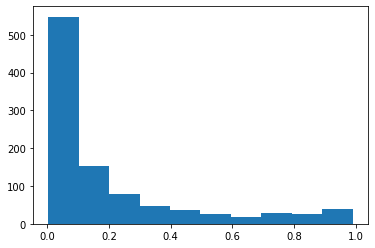

In [20]:
plt.hist(predictions)
plt.show()

In [21]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.3, 1, 0))

col_0,0,1
Exited,,
0,698,83
1,82,137


In [25]:
cm = pd.crosstab(index=test_data['Exited'], columns=np.round(predictions), rownames=['Observed'], colnames=['Predicted'])
tn = cm.iloc[0,0]; fn = cm.iloc[1,0]; tp = cm.iloc[1,1]; fp = cm.iloc[0,1]; p = (tp+tn)/(tp+tn+fp+fn)*100
print("\n{0:<20}{1:<4.1f}%\n".format("Overall Classification Rate: ", p))
print("{0:<15}{1:<15}{2:>8}".format("Predicted", "No Purchase", "Purchase"))
print("Observed")
print("{0:<15}{1:<2.0f}% ({2:<}){3:>6.0f}% ({4:<})".format("No Purchase", tn/(tn+fn)*100,tn, fp/(tp+fp)*100, fp))
print("{0:<16}{1:<1.0f}% ({2:<}){3:>7.0f}% ({4:<}) \n".format("Purchase", fn/(tn+fn)*100,fn, tp/(tp+fp)*100, tp))


Overall Classification Rate: 84.4%

Predicted      No Purchase    Purchase
Observed
No Purchase    86% (745)    27% (36)
Purchase        14% (120)     73% (99) 



In [39]:
linear_endpoint = 'DEMO-linear-endpoint-' + time.strftime("%Y%m%d%H%M", time.gmtime())
print(linear_endpoint)

DEMO-linear-endpoint-202010041358
